In [4]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

model_name = "openai/whisper-small"
processor = WhisperProcessor.from_pretrained(model_name)
model = WhisperForConditionalGeneration.from_pretrained(model_name)
model.save_pretrained("C:/Users/Ashish/transcript/goodnight-moon/1st_Place/assets/whisper-small.en")
processor.save_pretrained("C:/Users/Ashish/transcript/goodnight-moon/1st_Place/assets/whisper-small.en")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

C:\Users\Ashish\transcript\venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ashish\.cache\huggingface\hub\models--openai--whisper-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

C:\Users\Ashish\transcript\venv\Lib\site-packages\transformers\modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


[]

Transcribing with both models: 100%|███████████████████████████████████████████████████| 39/39 [03:52<00:00,  5.96s/it]


Comparison saved to comparison.csv

Baseline Whisper Avg Accuracy: 66.52%
Fine-Tuned Whisper Avg Accuracy: 64.70%


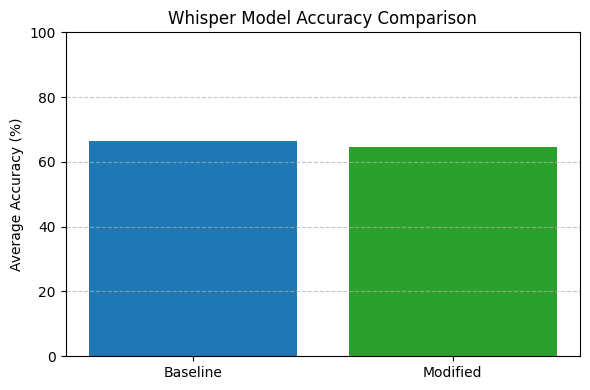

In [6]:
#comparing the whisper base model with finetune whisper base model on dataset a

import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from pydub import AudioSegment
from transformers import WhisperForConditionalGeneration, WhisperProcessor
import matplotlib.pyplot as plt

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

supported_formats = (".mp3", ".wav")  # Add other formats if needed

# Load the fine-tuned Whisper model
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/assets/whisper-base.en"
ft_processor = WhisperProcessor.from_pretrained(model_path)
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()


def custom_transcribe(audio_path):
    # Load and preprocess the audio
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    # Extract features
    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    # 🔥 Remove forced_decoder_ids from model config directly
    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None

    # Generate and decode
    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)

    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription


def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        # Load ground truth
        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline Whisper transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]
        base_error = jiwer.wer(ground_truth, base_text, truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100,0)

        # Fine-tuned Whisper transcription
        try:
            modified_text = custom_transcribe(file_path)
            mod_error = jiwer.wer(ground_truth, modified_text, truth_transform=transforms, hypothesis_transform=transforms)
            mod_accuracy = max((1 - mod_error) * 100,0)
        except Exception as e:
            modified_text = ""
            mod_accuracy = 0.0
            print(f"Error processing {filename} with fine-tuned model: {e}")

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetA.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

# Run transcription on the audio datasets
audio_dir = "dataset/a/"  
baseline_results, modified_results = transcribe_with_both_models(audio_dir)

# Save to CSV
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetA.csv")

# Print average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)
print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

# Plot Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()


Transcribing with both models: 100%|███████████████████████████████████████████████████| 51/51 [21:47<00:00, 25.64s/it]


Comparison saved to comparison.csv

Baseline Whisper Avg Accuracy: 52.37%
Fine-Tuned Whisper Avg Accuracy: 56.61%


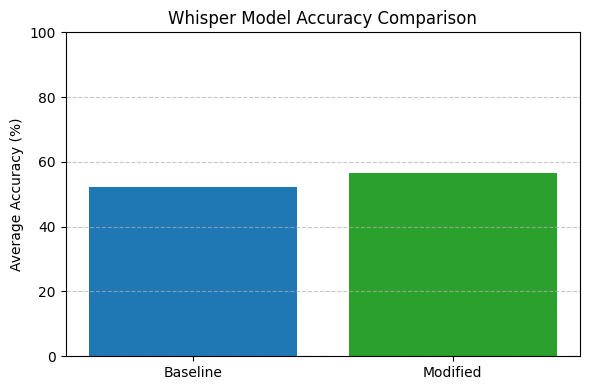

In [8]:
#comparing the whisper base model with finetune whisper base model on dataset b

import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from pydub import AudioSegment
from transformers import WhisperForConditionalGeneration, WhisperProcessor
import matplotlib.pyplot as plt

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

supported_formats = (".mp3", ".wav")  # Add other formats if needed

# Load the fine-tuned Whisper model
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/assets/whisper-base.en"
ft_processor = WhisperProcessor.from_pretrained(model_path)
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()


def custom_transcribe(audio_path):
    # Load and preprocess the audio
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    # Extract features
    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    # 🔥 Remove forced_decoder_ids from model config directly
    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None

    # Generate and decode
    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)

    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription


def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        # Load ground truth
        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline Whisper transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]
        base_error = jiwer.wer(ground_truth, base_text, truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100,0)

        # Fine-tuned Whisper transcription
        try:
            modified_text = custom_transcribe(file_path)
            mod_error = jiwer.wer(ground_truth, modified_text, truth_transform=transforms, hypothesis_transform=transforms)
            mod_accuracy = max((1 - mod_error) * 100,0)
        except Exception as e:
            modified_text = ""
            mod_accuracy = 0.0
            print(f"Error processing {filename} with fine-tuned model: {e}")

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetB.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

# Run transcription on the audio datasets
audio_dir = "dataset/b/"  
baseline_results, modified_results = transcribe_with_both_models(audio_dir)

# Save to CSV
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetB.csv")

# Print average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)
print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

# Plot Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()


Transcribing with both models: 100%|███████████████████████████████████████████████████| 39/39 [24:56<00:00, 38.38s/it]


Comparison saved to comparisonSmallModelDatasetA.csv

Baseline Whisper Avg Accuracy: 72.41%
Fine-Tuned Whisper Avg Accuracy: 76.91%


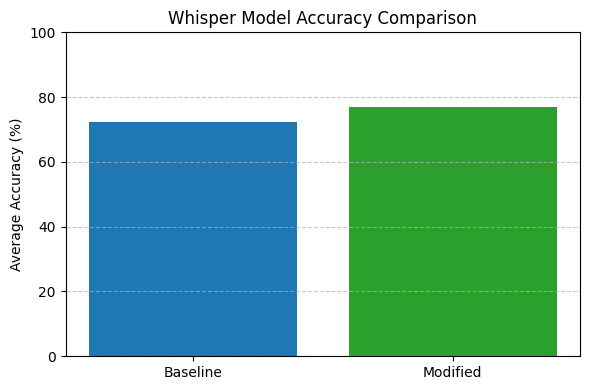

In [10]:
#comparing the whisper small model with finetune whisper small model on dataset a

import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from pydub import AudioSegment
from transformers import WhisperForConditionalGeneration, WhisperProcessor
import matplotlib.pyplot as plt

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

supported_formats = (".mp3", ".wav")  # Add other formats if needed

# Load the fine-tuned Whisper model
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/assets/whisper-small.en"
ft_processor = WhisperProcessor.from_pretrained(model_path)
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()


def custom_transcribe(audio_path):
    # Load and preprocess the audio
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    # Extract features
    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    # 🔥 Remove forced_decoder_ids from model config directly
    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None

    # Generate and decode
    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)

    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription


def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        # Load ground truth
        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline Whisper transcription
        base_model = whisper.load_model("small")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]
        base_error = jiwer.wer(ground_truth, base_text, truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100,0)

        # Fine-tuned Whisper transcription
        try:
            modified_text = custom_transcribe(file_path)
            mod_error = jiwer.wer(ground_truth, modified_text, truth_transform=transforms, hypothesis_transform=transforms)
            mod_accuracy = max((1 - mod_error) * 100,0)
        except Exception as e:
            modified_text = ""
            mod_accuracy = 0.0
            print(f"Error processing {filename} with fine-tuned model: {e}")

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results

def save_comparison_to_csv(baseline, modified, output_file="comparisonSmallModelDatasetA.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

# Run transcription on the audio datasets
audio_dir = "dataset/a/"  
baseline_results, modified_results = transcribe_with_both_models(audio_dir)

# Save to CSV
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonSmallModelDatasetA.csv")

# Print average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)
print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

# Plot Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()


Transcribing with both models: 100%|███████████████████████████████████████████████████| 51/51 [29:49<00:00, 35.08s/it]


Comparison saved to comparisonSmallModelDatasetB.csv

Baseline Whisper Avg Accuracy: 64.72%
Fine-Tuned Whisper Avg Accuracy: 67.42%


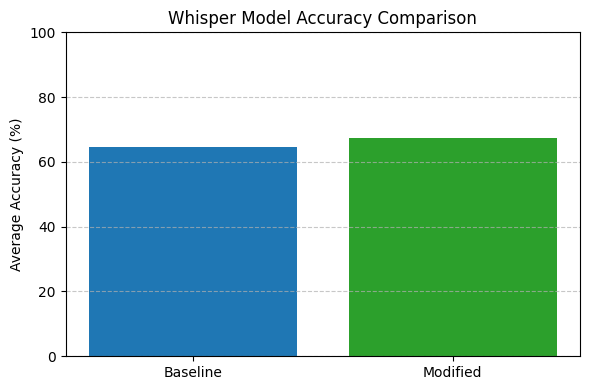

In [11]:
#comparing the whisper small model with finetune whisper small model on dataset b

import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from pydub import AudioSegment
from transformers import WhisperForConditionalGeneration, WhisperProcessor
import matplotlib.pyplot as plt

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

supported_formats = (".mp3", ".wav")  # Add other formats if needed

# Load the fine-tuned Whisper model
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/assets/whisper-small.en"
ft_processor = WhisperProcessor.from_pretrained(model_path)
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()


def custom_transcribe(audio_path):
    # Load and preprocess the audio
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    # Extract features
    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    # 🔥 Remove forced_decoder_ids from model config directly
    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None

    # Generate and decode
    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)

    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription


def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        # Load ground truth
        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline Whisper transcription
        base_model = whisper.load_model("small")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]
        base_error = jiwer.wer(ground_truth, base_text, truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100,0)

        # Fine-tuned Whisper transcription
        try:
            modified_text = custom_transcribe(file_path)
            mod_error = jiwer.wer(ground_truth, modified_text, truth_transform=transforms, hypothesis_transform=transforms)
            mod_accuracy = max((1 - mod_error) * 100,0)
        except Exception as e:
            modified_text = ""
            mod_accuracy = 0.0
            print(f"Error processing {filename} with fine-tuned model: {e}")

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results

def save_comparison_to_csv(baseline, modified, output_file="comparisonSmallModelDatasetB.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

# Run transcription on the audio datasets
audio_dir = "dataset/b/"  
baseline_results, modified_results = transcribe_with_both_models(audio_dir)

# Save to CSV
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonSmallModelDatasetB.csv")

# Print average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)
print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

# Plot Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()
